# Sharp wave-ripple network model using the new cell models

## Imports and basic declarations

In [1]:
#!/usr/bin/python
# -*- coding: utf8 -*-

from brian import *
import numpy as np
import matplotlib.pyplot as plt
import os
import gc
from detect_oscillations import replay, ripple, gamma
import random as pyrandom

In [2]:
fIn = 'wmxR.txt'

#SWBasePath = os.path.split(os.path.split(__file__)[0])[0] # '/home/bandi/workspace/KOKI/SharpWaves'
SWBasePath = '/'.join(os.path.abspath('__file__').split('/')[:-2])

figures_folder = '/'.join([SWBasePath, 'scripts', 'jupyter_figures'])
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

NE = 4000
NI = 1000

np.random.seed(123)
pyrandom.seed(123)

# sparseness
eps_pyr = 0.16
eps_bas = 0.4

### Pyramidal cell parameters

In [3]:
# parameters for pyr cells
pyr_params = np.genfromtxt('pyr_params.param')

z           = 1*nS
gL_Pyr      = pyr_params[0]     * uS
tauMem_Pyr  = pyr_params[1]     * ms
Cm_Pyr      = tauMem_Pyr * gL_Pyr
Vrest_Pyr   = pyr_params[2]     * mV
reset_Pyr   = pyr_params[3]     * mV
theta_Pyr   = pyr_params[4]     * mV
tref_Pyr    = pyr_params[5]     * ms

# Adaptation parameters for pyr cells
a_Pyr       = pyr_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Pyr       = pyr_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Pyr = pyr_params[8] * mV              # Slope factor
tau_w_Pyr   = pyr_params[9] * ms              # Adaptation time constant
v_spike_Pyr = theta_Pyr + 10 * delta_T_Pyr

### Basket cell parameters

In [4]:
# parameters for bas cells
bas_params = np.genfromtxt('bas_params.param')

gL_Bas      = bas_params[0] * uS
tauMem_Bas  = bas_params[1] * ms
Cm_Bas      = tauMem_Bas * gL_Bas
Vrest_Bas   = bas_params[2] * mV
reset_Bas   = bas_params[3] * mV
theta_Bas   = bas_params[4] * mV
tref_Bas    = bas_params[5] * ms

# Adaptation parameters for pyr cells
a_Bas       = bas_params[6] * nS              # nS    Subthreshold adaptation conductance
b_Bas       = bas_params[7] * nA              # nA    Spike-triggered adaptation
delta_T_Bas = bas_params[8] * mV              # Slope factor
tau_w_Bas   = bas_params[9] * ms              # Adaptation time constant
v_spike_Bas = theta_Bas + 10 * delta_T_Bas

### Synaptic parameters

In [5]:
# synaptic weights
J_PyrInh = 0.04 #0.04
J_BasExc = 32.
J_BasInh = 8.

# Synaptic reversal potentials
E_Exc = 0.0*mV
E_Inh = -70.0*mV

# Synaptic time constants
tauSyn_PyrExc = 10.0*ms
tauSyn_PyrInh = 3.0*ms * 1.1 #* 1.3
tauSyn_BasExc = 3.0*ms
tauSyn_BasInh = 1.5*ms * 0.67

# Synaptic delays
delay_PyrExc = 3.0*ms
delay_PyrInh = 1.5*ms * 1.3 # ezt is ki lehet kommentelni
delay_BasExc = 3.0*ms
delay_BasInh = 1.5*ms * 0.6 #* 0.55

# input parameters
p_rate_mf = 25. * Hz #5. * Hz #25.*Hz
J_PyrMF = 18. #45.5 #18.

In [6]:
print 'J_PyrInh:', J_PyrInh
print 'J_BasExc:', J_BasExc
print 'J_BasInh:', J_BasInh

J_PyrInh: 0.04
J_BasExc: 32.0
J_BasInh: 8.0


### Cell model definitions

In [7]:
eqs_adexp = '''
dvm/dt = (-gL_Pyr*(vm-Vrest_Pyr) + gL_Pyr*delta_T_Pyr*exp((vm- theta_Pyr)/delta_T_Pyr)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Pyr : volt
dw/dt = (a_Pyr*(vm- Vrest_Pyr )-w)/tau_w_Pyr : amp
dg_ampa/dt = -g_ampa/tauSyn_PyrExc : 1
dg_gaba/dt = -g_gaba/tauSyn_PyrInh : 1
'''

reset_adexp = '''
vm = reset_Pyr
w += b_Pyr
'''

# Bence
eqs_bas = '''
dvm/dt = (-gL_Bas*(vm-Vrest_Bas) + gL_Bas*delta_T_Bas*exp((vm- theta_Bas)/delta_T_Bas)-w - (g_ampa*z*(vm-E_Exc) + g_gaba*z*(vm-E_Inh)))/Cm_Bas : volt
dw/dt = (a_Bas*(vm- Vrest_Bas )-w)/tau_w_Bas : amp
dg_ampa/dt = -g_ampa/tauSyn_BasExc : 1
dg_gaba/dt = -g_gaba/tauSyn_BasInh : 1
'''

reset_basket = '''
vm = reset_Bas
w += b_Bas
'''

def myresetfunc(P, spikes):
    P.vm[spikes] = reset_Pyr    # reset voltage
    P.w[spikes] += b_Pyr        # low pass filter of spikes (adaptation mechanism)

# Bence
def basresetfunc(P, spikes):
    P.vm[spikes] = reset_Bas
    P.w[spikes] += b_Bas

SCR     = SimpleCustomRefractoriness(myresetfunc, tref_Pyr, state='vm')
SCR_Bas = SimpleCustomRefractoriness(basresetfunc, tref_Bas, state='vm')

## Creating and initializing populations

In [8]:
PE = NeuronGroup(NE, model=eqs_adexp, threshold=v_spike_Pyr, reset=SCR)
PI = NeuronGroup(NI, model=eqs_bas,   threshold=v_spike_Bas, reset=SCR_Bas)

PE.vm = Vrest_Pyr
PE.g_ampa = 0
PE.g_gaba = 0

PI.vm  = Vrest_Bas
PI.g_ampa = 0
PI.g_gaba = 0

MF = PoissonGroup(NE, p_rate_mf)

## Connecting the network

In [9]:
print 'Connecting the network'

Cext = IdentityConnection(MF, PE, 'g_ampa', weight=J_PyrMF)

Cee = Connection(PE, PE, 'g_ampa', delay=delay_PyrExc)

fName = os.path.join(SWBasePath, 'files', fIn)
Wee = np.genfromtxt(fName) * 1.e9 * 4.0
np.fill_diagonal(Wee, 0)
gc.collect()

Cee.connect(PE, PE, Wee)

Cei = Connection(PE, PI, 'g_ampa', weight=J_BasExc, sparseness=eps_pyr, delay=delay_BasExc)
Cie = Connection(PI, PE, 'g_gaba', weight=J_PyrInh, sparseness=eps_bas, delay=delay_PyrInh)
Cii = Connection(PI, PI, 'g_gaba', weight=J_BasInh, sparseness=eps_bas, delay=delay_BasInh)

print 'Connections done'

Connecting the network
Connections done


## Defining the monitors

In [10]:
# Monitors
sme     = SpikeMonitor(PE)
smi     = SpikeMonitor(PI)
popre   = PopulationRateMonitor(PE, bin=1*ms)
popri   = PopulationRateMonitor(PI, bin=1*ms)
poprext = PopulationRateMonitor(MF, bin=1*ms)
bins    = [0*ms, 50*ms, 100*ms, 150*ms, 200*ms, 250*ms, 300*ms, 350*ms, 400*ms, 450*ms, 500*ms,
           550*ms, 600*ms, 650*ms, 700*ms, 750*ms, 800*ms, 850*ms, 900*ms, 950*ms, 1000*ms]
isi     = ISIHistogramMonitor(PE, bins)

#p_volt = StateMonitor(PE, 'vm', record=[2062, 2209])
#p_ampa = StateMonitor(PE, 'g_ampa', record=[2062, 2209])
#p_gava = StateMonitor(PE, 'g_gaba', record=[2062, 2209])
#pyr_exc_inp = StateMonitor(PE, 'g_ampa', record=0)
#pyr_inh_inp = StateMonitor(PE, 'g_gaba', record=0)
#bas_exc_inp = StateMonitor(PE, 'g_ampa', record=0)
#bas_inh_inp = StateMonitor(PE, 'g_gaba', record=0)
#pyr_volt = StateMonitor(PE, 'vm', record=[0, 125, 3968])        # Wee[0,125] is the biggest value of the first row
#bas_volt = StateMonitor(PI, 'vm', record=0)

## Running the simulation

In [11]:
run(10000*ms, report='text')

11% complete, 10s elapsed, approximately 1m 15s remaining.
20% complete, 20s elapsed, approximately 1m 18s remaining.
30% complete, 30s elapsed, approximately 1m 8s remaining.
42% complete, 40s elapsed, approximately 54s remaining.
54% complete, 50s elapsed, approximately 41s remaining.
65% complete, 1m 0s elapsed, approximately 31s remaining.
76% complete, 1m 10s elapsed, approximately 21s remaining.
86% complete, 1m 20s elapsed, approximately 12s remaining.
96% complete, 1m 30s elapsed, approximately 3s remaining.
100% complete, 1m 33s elapsed, approximately 0s remaining.


In [12]:
# total number or spikes per population
print sme.nspikes
print smi.nspikes

76866
1089750


## Analysis of the oscillations

In [13]:
avgReplayInterval = replay(isi.count[3:17])  # bins from 150 to 850 (range of interest)

meanEr, rEAC, maxEAC, tMaxEAC, maxEACR, tMaxEACR, fE, PxxE, avgRippleFE, ripplePE = ripple(popre.rate, 1000)
avgGammaFE, gammaPE = gamma(fE, PxxE)
meanIr, rIAC, maxIAC, tMaxIAC, maxIACR, tMaxIACR, fI, PxxI, avgRippleFI, ripplePI = ripple(popri.rate, 1000)
avgGammaFI, gammaPI = gamma(fI, PxxI)

print 'Mean excitatory rate: ', meanEr
print 'Maximum exc. autocorrelation:', maxEAC, 'at', tMaxEAC, '[ms]'
print 'Maximum exc. AC in ripple range:', maxEACR, 'at', tMaxEACR, '[ms]'
print 'Mean inhibitory rate: ', meanIr
print 'Maximum inh. autocorrelation:', maxIAC, 'at', tMaxIAC, '[ms]'
print 'Maximum inh. AC in ripple range:', maxIACR, 'at', tMaxIACR, '[ms]'
print ''
print 'Average exc. ripple freq:', avgRippleFE
print 'Exc. ripple power:', ripplePE
print 'Average exc. gamma freq:', avgGammaFE
print 'Exc. gamma power:', gammaPE
print 'Average inh. ripple freq:', avgRippleFI
print 'Inh. ripple power:', ripplePI
print 'Average inh. gamma freq:', avgGammaFI
print 'Inh. gamma power:', gammaPI

Replay, avg. replay interval: 475.112669354 [ms]
Mean excitatory rate:  1.92165
Maximum exc. autocorrelation: 0.563406177108 at 6 [ms]
Maximum exc. AC in ripple range: 0.563406177108 at 6 [ms]
Mean inhibitory rate:  108.975
Maximum inh. autocorrelation: 0.703740792269 at 6 [ms]
Maximum inh. AC in ripple range: 0.703740792269 at 6 [ms]

Average exc. ripple freq: 173.828125
Exc. ripple power: 61.7136636716
Average exc. gamma freq: nan
Exc. gamma power: 14.5235406409
Average inh. ripple freq: 173.828125
Inh. ripple power: 59.8378977186
Average inh. gamma freq: nan
Inh. gamma power: 1.61821027374


## Plots

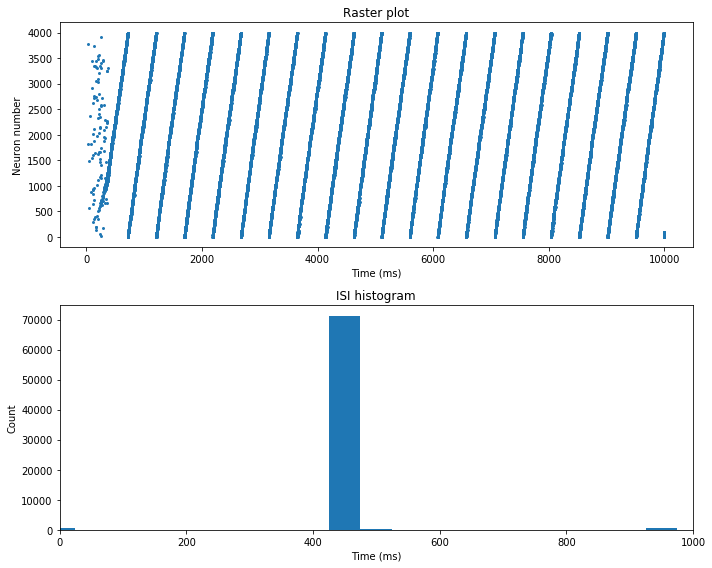

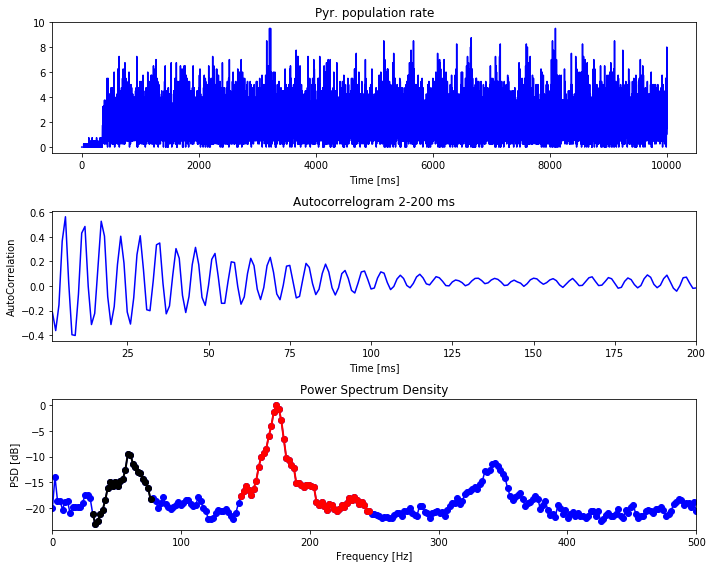

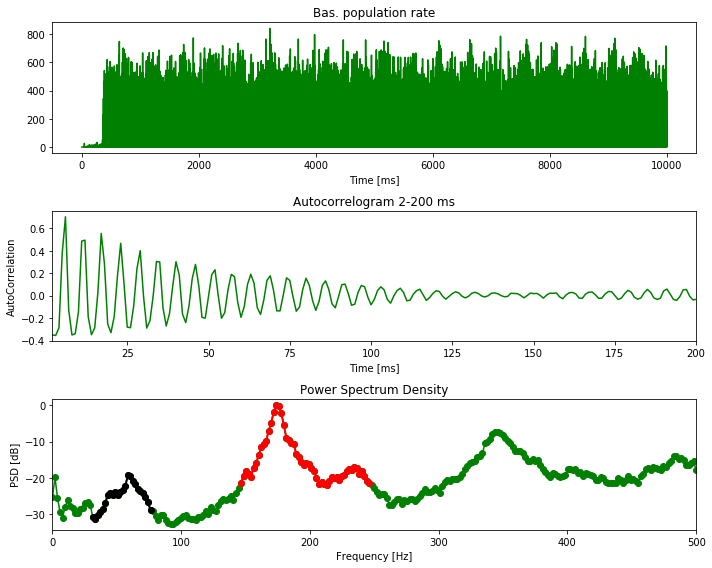

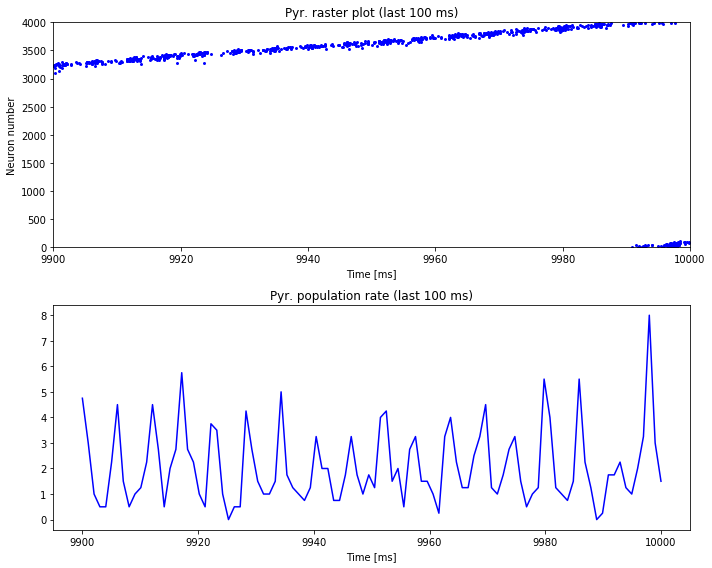

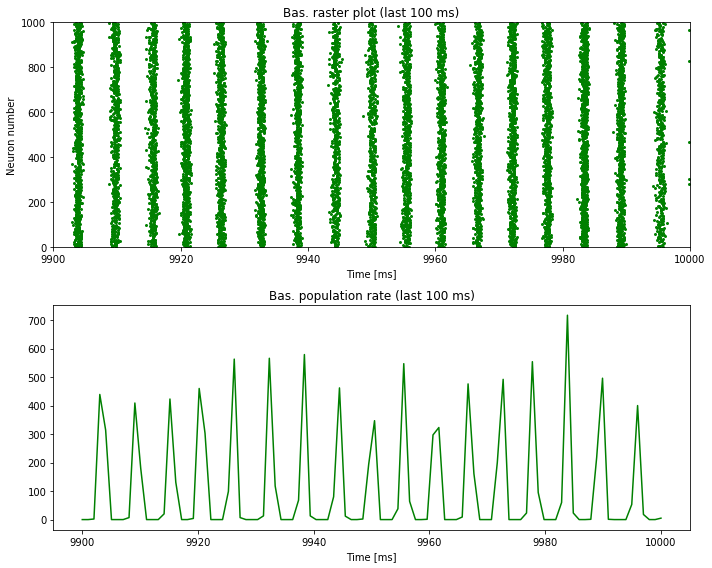

In [14]:
# Plots
% matplotlib inline

fig = plt.figure(figsize=(10, 8))

subplot(2, 1, 1)
raster_plot(sme, spacebetweengroups=1, title='Raster plot', newfigure=False)

subplot(2, 1, 2)
hist_plot(isi, title='ISI histogram', newfigure=False)
xlim([0, 1000])

fig.tight_layout()
plt.savefig(figures_folder + '/raster_isihist.png')

# Pyr population
fig2 = plt.figure(figsize=(10, 8))

ax = fig2.add_subplot(3, 1, 1)
ax.plot(np.linspace(0, 10000, len(popre.rate)), popre.rate, 'b-')
ax.set_title('Pyr. population rate')
ax.set_xlabel('Time [ms]')

# Bence
#plt.show()

rEACPlot = rEAC[2:201]  # 500 - 5 Hz interval

ax2 = fig2.add_subplot(3, 1, 2)
ax2.plot(np.linspace(2, 200, len(rEACPlot)), rEACPlot, 'b-')
ax2.set_title('Autocorrelogram 2-200 ms')
ax2.set_xlabel('Time [ms]')
ax2.set_xlim([2, 200])
ax2.set_ylabel('AutoCorrelation')

PxxEPlot = 10 * np.log10(PxxE / max(PxxE))

fE = np.asarray(fE)
rippleS = np.where(145 < fE)[0][0]
rippleE = np.where(fE < 250)[0][-1]
gammaS = np.where(30 < fE)[0][0]
gammaE = np.where(fE < 80)[0][-1]
fE.tolist()

PxxRipple = PxxE[rippleS:rippleE]
PxxGamma = PxxE[gammaS:gammaE]

fRipple = fE[rippleS:rippleE]
fGamma = fE[gammaS:gammaE]

PxxRipplePlot = 10 * np.log10(PxxRipple / max(PxxE))
PxxGammaPlot = 10 * np.log10(PxxGamma / max(PxxE))

ax3 = fig2.add_subplot(3, 1, 3)
ax3.plot(fE, PxxEPlot, 'b-', marker='o', linewidth=1.5)
ax3.plot(fRipple, PxxRipplePlot, 'r-', marker='o', linewidth=2)
ax3.plot(fGamma, PxxGammaPlot, 'k-', marker='o', linewidth=2)
ax3.set_title('Power Spectrum Density')
ax3.set_xlim([0, 500])
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('PSD [dB]')

fig2.tight_layout()
plt.savefig(figures_folder + '/pyr_poprate_autocorr_psd.png')

# Bas population
fig3 = plt.figure(figsize=(10, 8))

ax = fig3.add_subplot(3, 1, 1)
ax.plot(np.linspace(0, 10000, len(popri.rate)), popri.rate, 'g-')
ax.set_title('Bas. population rate')
ax.set_xlabel('Time [ms]')

rIACPlot = rIAC[2:201] # 500 - 5 Hz interval

ax2 = fig3.add_subplot(3, 1, 2)
ax2.plot(np.linspace(2, 200, len(rIACPlot)), rIACPlot, 'g-')
ax2.set_title('Autocorrelogram 2-200 ms')
ax2.set_xlabel('Time [ms]')
ax2.set_xlim([2, 200])
ax2.set_ylabel('AutoCorrelation')

PxxIPlot = 10 * np.log10(PxxI / max(PxxI))

fI = np.asarray(fI)
rippleS = np.where(145 < fI)[0][0]
rippleE = np.where(fI < 250)[0][-1]
gammaS = np.where(30 < fI)[0][0]
gammaE = np.where(fI < 80)[0][-1]
fI.tolist()

PxxRipple = PxxI[rippleS:rippleE]
PxxGamma = PxxI[gammaS:gammaE]

fRipple = fI[rippleS:rippleE]
fGamma = fI[gammaS:gammaE]

PxxRipplePlot = 10 * np.log10(PxxRipple / max(PxxI))
PxxGammaPlot = 10 * np.log10(PxxGamma / max(PxxI))

ax3 = fig3.add_subplot(3, 1, 3)
ax3.plot(fI, PxxIPlot, 'g-', marker='o', linewidth=1.5)
ax3.plot(fRipple, PxxRipplePlot, 'r-', marker='o', linewidth=2)
ax3.plot(fGamma, PxxGammaPlot, 'k-', marker='o', linewidth=2)
ax3.set_title('Power Spectrum Density')
ax3.set_xlim([0, 500])
ax3.set_xlabel('Frequency [Hz]')
ax3.set_ylabel('PSD [dB]')

fig3.tight_layout()
plt.savefig(figures_folder + '/bas_poprate_autocorr_psd.png')

# raster plot and rate pyr (higher resolution)
fig4 = plt.figure(figsize=(10, 8))

spikes = sme.spikes
spikingNeurons = [i[0] for i in spikes]
spikeTimes = [i[1] for i in spikes]

tmp = np.asarray(spikeTimes)
ROI = np.where(tmp > 9.9)[0].tolist()

rasterX = np.asarray(spikeTimes)[ROI] * 1000
rasterY = np.asarray(spikingNeurons)[ROI]

if rasterY.min()-50 > 0:
    ymin = rasterY.min()-50
else:
    ymin = 0

if rasterY.max()+50 < 4000:
    ymax = rasterY.max()+50
else:
    ymax = 4000

ax = fig4.add_subplot(2, 1, 1)
ax.scatter(rasterX, rasterY, c='blue', marker='.', lw=0)
ax.set_title('Pyr. raster plot (last 100 ms)')
ax.set_xlim([9900, 10000])
ax.set_xlabel('Time [ms]')
ax.set_ylim([ymin, ymax])
ax.set_ylabel('Neuron number')

ax2 = fig4.add_subplot(2, 1, 2)
ax2.plot(np.linspace(9900, 10000, len(popre.rate[9900:10000])), popre.rate[9900:10000], 'b-', linewidth=1.5)
ax2.set_title('Pyr. population rate (last 100 ms)')
ax2.set_xlabel('Time [ms]')

fig4.tight_layout()
plt.savefig(figures_folder + '/pyr_raster_poprate_last100.png')

# raster plot and rate bas (higher resolution)
fig5 = plt.figure(figsize=(10, 8))

spikes = smi.spikes
spikingNeurons = [i[0] for i in spikes]
spikeTimes = [i[1] for i in spikes]

tmp = np.asarray(spikeTimes)
ROI = np.where(tmp > 9.9)[0].tolist()

rasterX = np.asarray(spikeTimes)[ROI] * 1000
rasterY = np.asarray(spikingNeurons)[ROI]

if rasterY.min()-50 > 0:
    ymin = rasterY.min()-50
else:
    ymin = 0

if rasterY.max()+50 < 1000:
    ymax = rasterY.max()+50
else:
    ymax = 1000

ax = fig5.add_subplot(2, 1, 1)
ax.scatter(rasterX, rasterY, c='green', marker='.', lw=0)
ax.set_title('Bas. raster plot (last 100 ms)')
ax.set_xlim([9900, 10000])
ax.set_xlabel('Time [ms]')
ax.set_ylim([ymin, ymax])
ax.set_ylabel('Neuron number')

ax2 = fig5.add_subplot(2, 1, 2)
ax2.plot(np.linspace(9900, 10000, len(popri.rate[9900:10000])), popri.rate[9900:10000], 'g-', linewidth=1.5)
ax2.set_title('Bas. population rate (last 100 ms)')
ax2.set_xlabel('Time [ms]')

fig5.tight_layout()
plt.savefig(figures_folder + '/bas_raster_poprate_last100.png')

plt.show()

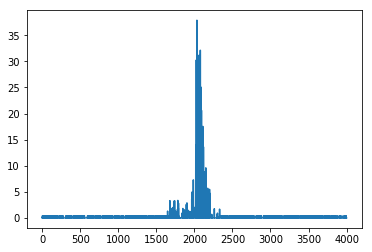

In [15]:
plot(Wee[2000, :])

In [16]:
sp = [tup for tup in sme.spikes if (tup[1] / msecond >= 9900 and tup[1] / msecond <= 9980)]

In [17]:
sp = np.array(sp)

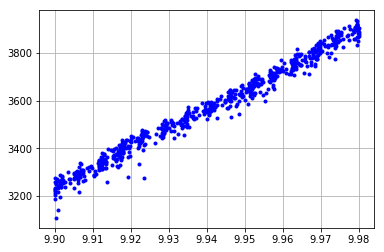

In [18]:
plot(sp[:,1], sp[:,0], 'b.')
plt.grid(b='on', which='both')